## Transmission Rate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
from pyparsing import python_style_comment
from itertools import islice
import scipy.sparse as sps
from scipy.sparse import diags
from functools import lru_cache

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table
import dataframe_image as dfi



from scipy.special import comb as combination



In [26]:
comb_cache = {}

@lru_cache(maxsize=None)

def compute_N(n_BPPM):
  def agen(): # generator of terms
      aset, sset, k = set(), set(), 0
      while True:
          k += 1
          while any(k+an in sset for an in aset): k += 1
          yield k; sset.update(k+an for an in aset); aset.add(k)
  a = list(islice(agen(), 200))
  photon = list(map(lambda v: v-1, a))
  compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  return compute_N[n_BPPM]
    

In [29]:

#rate  = bit / time bin

df_transmission_rate_BPPM = pd.DataFrame(columns=[
                                    'Photon Number_BPPM', 
                                 'Time Bin_BPPM',
                                 'Transmission Rate_BPPM',
                                ]
                                 )

for n_BPPM in range(3,150):
    n_PPM = 1
    n_General = 2
    N_n = compute_N(n_BPPM)
    factorial_n = math.factorial(n_BPPM)
    K_BPPM = np.log2(float(factorial_n))
    rate_BPPM = np.log2(K_BPPM) / N_n
    df_transmission_rate_BPPM.loc[n_BPPM-1] = [n_BPPM, N_n, rate_BPPM]

In [48]:
import numpy as np

#rate  = bit / time bin

df_transmission_rate = pd.DataFrame(columns=[ 
                                 'Time Bin',
                                 'Transmission Rate_PPM',
                                 'Transmission Rate_G for n =2', 
                                 'Transmission Rate_G for n =3'
                                ]
                                 )

for M in range(3,1000):
    n_PPM = 1
    n_General_2 = 2
    n_General_3 = 3
    rate_PPM = np.log2(M) / M
    K_General_2 = np.log2(float(math.factorial(M) / (math.factorial(M-2) * math.factorial(2))))
    K_General_3 = np.log2(float(math.factorial(M) / (math.factorial(M-3) * math.factorial(3))))
    rate_G_2 =  K_General_2 / M 
    rate_G_3 =  K_General_3 / M
    df_transmission_rate.loc[M-1] = [M, rate_PPM, rate_G_2,rate_G_3]

In [49]:
math.factorial(4) / (math.factorial(4-2) * math.factorial(2))  / 4

1.5

In [50]:
math.factorial(4) / (math.factorial(4-3) * math.factorial(3))  / 4

1.0

In [51]:
df_concat_transmission = pd.concat([df_transmission_rate_BPPM, df_transmission_rate.iloc[:, :4]], axis=1)
df_concat_transmission

,Photon Number_BPPM,Time Bin_BPPM,Transmission Rate_BPPM,Time Bin,Transmission Rate_PPM,Transmission Rate_G for n =2,Transmission Rate_G for n =3
2,3.0,7.0,0.195735,3.0,0.528321,0.528321,0.000000
3,4.0,14.0,0.156922,4.0,0.500000,0.646241,0.500000
4,5.0,26.0,0.107232,5.0,0.464386,0.664386,0.664386
5,6.0,46.0,0.070580,6.0,0.430827,0.651148,0.720321
6,7.0,75.0,0.048273,7.0,0.401051,0.627474,0.732755
...,...,...,...,...,...,...,...
994,NaN,NaN,NaN,995.0,0.010009,0.019011,0.027423
995,NaN,NaN,NaN,996.0,0.010000,0.018995,0.027400
996,NaN,NaN,NaN,997.0,0.009991,0.018978,0.027377
997,NaN,NaN,NaN,998.0,0.009983,0.018962,0.027354


In [52]:
df_concat_transmission.to_excel('transmission_rate_updated.xlsx', index=False)

In [104]:
comb_cache = {}
comb_n_cache = {}
comb_n_M_minus_n_cache = {}

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N

def combination(n, r):
    if (n, r) in comb_cache:
        return comb_cache[(n, r)]
    else:
        comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
        comb_cache[(n, r)] = comb
        return comb
    
@lru_cache(maxsize=None)
def compute_N(n):
  def agen(): # generator of terms
      aset, sset, k = set(), set(), 0
      while True:
          k += 1
          while any(k+an in sset for an in aset): k += 1
          yield k; sset.update(k+an for an in aset); aset.add(k)
  a = list(islice(agen(), 100))
  photon = list(map(lambda v: v-1, a))
  compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  return compute_N[n]

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute(n, P_l, l):
    if (n, l) in comb_n_cache:
        comb_n = comb_n_cache[(n, l)]
    else:
        comb_n = combination(n, l)
        comb_n_cache[(n, l)] = comb_n

    return comb_n * (P_l)**l * (1 - P_l)**(n - l)


def Add_Distribute(n, P_a, a):
    N_n = compute_N(n)
    M_minus_n = compute_N(n) - N_n
    if (N_n, M_minus_n, a) in comb_n_M_minus_n_cache:
        comb_Nn_Mn = comb_n_M_minus_n_cache[(N_n, M_minus_n, a)]
    else:
        comb_Nn_Mn = combination(N_n + M_minus_n, a)
        comb_n_M_minus_n_cache[(N_n, M_minus_n, a)] = comb_Nn_Mn

    return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

# define a separate function for computing the probability of error
def P_err(n, P_l, P_a,l,a):
  return Loss_Distribute(n,P_l,l) * Add_Distribute(n,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

# We put these into P_D for re-normalization, These are the probability of error we can correct
# define separate functions for computing the probability of success
def P_Success0(n,P_l,P_a,l,a):
  return P_err(n,P_l, P_a,0,0)

def P_Success1(n,P_l,P_a,l,a):
  P0 = P_Success0(n, P_l, P_a,l,a)
  P1 = P_err(n, P_l, P_a, l=0, a=1) + P_err(n, P_l, P_a, l=1, a=0)
  return P0 + P1

def P_Success2(n,P_l,P_a,l,a):
  P1 = P_Success1(n, P_l, P_a)
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  return P1 + P2

def P_Success3(n,P_l,P_a,l,a):
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  P3 = P_err(n, P_l, P_a,1,2) + P_err(n, P_l, P_a, 2,1) + P_err(n, P_l, P_a,3,0) + P_err(n, P_l, P_a,0,3)
  return P2 + P3

def P_D(n,P_l,P_a,l,a):
# we only consider at most 1 error, i.e. P_0 + P_1
  return 1 - P_Success1(n,P_l,P_a,l,a)

In [105]:
def P_AB_BPPM_diagonal(n, P_D):
    factorial_n = math.factorial(n)
    diag_data = (1/factorial_n) * (1-P_D) 
    # matrix = sps.dia_matrix((diag_data, 0), shape=(factorial_n, factorial_n))
    return diag_data

def P_A_BPPM_diagonal(P_AB_BPPM_diagonal, P_D):
    if P_D == 1:
        return [1 for row in P_AB_BPPM_diagonal]
    else:
        return [1/(1-P_D) * sum(row) for row in P_AB_BPPM_diagonal] 
# sum over the elements in columns in the probability matrix P_AB
# renormalized in P_AB already

def P_B_BPPM_diagonal(P_AB_BPPM_diagonal, P_D):
    if P_D == 1:
        return [1 for col in zip(*P_AB_BPPM_diagonal)]
    else:
        return [1/(1-P_D) * sum(col) for col in zip(*P_AB_BPPM_diagonal)]

def H_AB_BPPM_diagonal(P_AB_BPPM_diagonal, P_D):
    factorial_n = math.factorial(n)
    P_AB_BPPM_diagonal = np.where(P_AB_BPPM_diagonal == 0, 1e-9, P_AB_BPPM_diagonal)  # replace zero values with 1e-9
    H = - factorial_n * (P_AB_BPPM_diagonal * np.log2(np.where(P_AB_BPPM_diagonal == 0, 1, P_AB_BPPM_diagonal))).sum()
    return H
    
def I_AB_BPPM_diagonal(P_AB_BPPM_diagonal, P_D):
    factorial_n = math.factorial(n)
    H_AB_BPPM_diag = H_AB_BPPM_diagonal(P_AB_BPPM_diagonal, P_D)
    I_AB = H_AB_BPPM_diag *(1-P_D) 
    return I_AB

# PPM 

In [98]:
def compute_M(n_BPPM):
  return n_BPPM

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_PPM(M, n_PPM):
    return math.factorial((int(M))) / (math.factorial((int(M - n_PPM))) * math.factorial((int(n_PPM))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_PPM(n_PPM, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n_PPM, l) * (P_l)**l * (1 - P_l)**(n_PPM - l)

def Add_Distribute_PPM(n_PPM, P_a, a):
    M = compute_M(n_BPPM)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(M - n_PPM, a) * (P_a)**a * (1 - P_a)**(M - n_PPM - a)

# define a separate function for computing the probability of error
def P_err_PPM(n_PPM, P_l, P_a,l,a):
  return Loss_Distribute(n_PPM,P_l,l) * Add_Distribute(n_PPM,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

def P_Success_PPM(n_PPM,P_l,P_a,l,a):
  return P_err_PPM(n_PPM,P_l, P_a, l=0, a=0) 

def P_D_PPM(n_PPM,P_l,P_a, l=0,a=0):
  return 1 - P_Success_PPM(n_PPM,P_l,P_a, l=0, a=0)

# sum over the elements in rows in the probability matrix P_AB
def P_A_PPM(P_AB_PPM, P_D_PPM):
    if P_D_PPM == 1:
        return [1 for row in P_AB_PPM]
    else:
        return [sum(row) for row in P_AB_PPM] # 1/(1-P_D_PPM)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_PPM(P_AB_PPM):
    if P_D == 1:
        return [1 for col in zip(*P_AB_PPM)]
    else:
        return [sum(col) for col in zip(*P_AB_PPM)]


def I_AB_PPM(H_A_PPM, H_B_PPM, H_AB_PPM, P_D_PPM):
    if np.isnan(H_AB_PPM):
        return 0
    else:
        return ((H_A_PPM + H_B_PPM - H_AB_PPM)) * (1-P_D_PPM)

In [99]:
def P_AB_PPM(M):
    matrix =  np.eye(2*M) * 1/(2*M)  #[[1/M * P_AB_PPM[i] if i == j else 0 for j in range(M)] for i in range(M)]
    return matrix 

def H_A_PPM(P_AB_PPM):
     P_A_PPM = np.sum(P_AB_PPM, axis=1)
     H_a_PPM = np.sum(-P_A_PPM * np.log2(np.where(P_A_PPM == 0, 1, P_A_PPM)))
     return H_a_PPM

def H_B_PPM(P_AB_PPM):
     P_B_PPM = np.sum(P_AB_PPM, axis=0)
     H_b_PPM = np.sum(-P_B_PPM * np.log2(np.where(P_B_PPM == 0, 1, P_B_PPM)))
     return H_b_PPM

def H_AB_PPM(P_AB_PPM):
    P_AB_PPM = np.where(P_AB_PPM == 0, 1e-9, P_AB_PPM)  # replace zero values with 1e-9
    H_PPM = -(P_AB_PPM * np.log2(P_AB_PPM)).sum()
    return H_PPM

In [100]:
# def compute_M(n_BPPM):
#     return n_BPPM

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_PPM(M, n_PPM):
    return math.factorial((int(M))) / (math.factorial((int(M - n_PPM))) * math.factorial((int(n_PPM))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_PPM(n_PPM, P_l, l):
      return combination(n_PPM, l) * (P_l)**l * (1 - P_l)**(n_PPM - l)



def Add_Distribute_PPM(n_PPM,P_a, a):
    return combination(M - n_PPM, a) * (P_a)**a * (1 - P_a)**(M - n_PPM - a)


# define a separate function for computing the probability of error
def P_err_PPM(n_PPM, P_l, P_a,l,a):
  return Loss_Distribute_PPM(n_PPM,P_l,l) * Add_Distribute_PPM(n_PPM,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

def P_Success_PPM(n_PPM,P_l,P_a,l,a):
  return P_err_PPM(n_PPM,P_l, P_a, l=0, a=0) 

# Perr[l = 0, a = 0, n = 1, N = M, Ploss, Padd] from mathematica

def P_D_PPM(n_PPM,P_l,P_a, l=0,a=0):
  return 1 - P_Success_PPM(n_PPM,P_l,P_a, l=0, a=0)

def I_AB_PPM(H_A_PPM, H_B_PPM, H_AB_PPM, P_D_PPM):
    if np.isnan(H_AB_PPM):
        return 0
    else:
        return ((H_A_PPM + H_B_PPM - H_AB_PPM)) * (1-P_D_PPM)


In [101]:
def P_AB_PPM(M):
    matrix =  np.eye(2*M) * 1/(2*M)  #[[1/M * P_AB_PPM[i] if i == j else 0 for j in range(M)] for i in range(M)]
    return matrix 

# sum over the elements in rows in the probability matrix P_AB
def P_A_PPM(P_AB_PPM, P_D_PPM):
    if P_D_PPM == 1:
        return [1 for row in P_AB_PPM]
    else:
        return [sum(row) for row in P_AB_PPM] # 1/(1-P_D_PPM)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_PPM(P_AB_PPM):
    if P_D == 1:
        return [1 for col in zip(*P_AB_PPM)]
    else:
        return [sum(col) for col in zip(*P_AB_PPM)]
def H_A_PPM(P_AB_PPM):
     P_A_PPM = np.sum(P_AB_PPM, axis=1)
     H_a_PPM = np.sum(-P_A_PPM * np.log2(np.where(P_A_PPM == 0, 1, P_A_PPM)))
     return H_a_PPM

def H_B_PPM(P_AB_PPM):
     P_B_PPM = np.sum(P_AB_PPM, axis=0)
     H_b_PPM = np.sum(-P_B_PPM * np.log2(np.where(P_B_PPM == 0, 1, P_B_PPM)))
     return H_b_PPM

def H_AB_PPM(P_AB_PPM):
    P_AB_PPM = np.where(P_AB_PPM == 0, 1e-9, P_AB_PPM)  # replace zero values with 1e-9
    H_PPM = -(P_AB_PPM * np.log2(P_AB_PPM)).sum()
    return H_PPM

# General

In [102]:
def Compute_G_n(n_General):
    return n_General

def compute_T_General(T_General):
  return T_General

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_General(T_General, n_General):
    return math.factorial(((T_General))) / (math.factorial(((T_General-n_General))) * math.factorial(((n_General))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_General(n_General, P_l, l):
      return combination(n_General, l) * (P_l)**l * (1 - P_l)**(n_General - l)

def Add_Distribute_General(n_General, T_General, P_a, a):
    return combination(T_General - n_General, a) * (P_a)**a * (1 - P_a)**(T_General - n_General - a)

# define a separate function for computing the probability of error
def P_err_General(n_General, T_General, P_l, P_a,l,a):
  return Loss_Distribute_General(n_General,P_l,l) * Add_Distribute_General(n_General,T_General, P_a, a)

def P_Success_General(n_General,T_General, P_l,P_a,l,a):
  return P_err_General(n_General,T_General, P_l, P_a, l=0, a=0) 

def P_D_General(n_General,T_General, P_l,P_a, l=0,a=0):
  return 1 - P_Success_General(n_General,T_General, P_l,P_a, l=0, a=0)

def P_A_General(P_AB_General, P_D_General):
    if P_D_General == 1:
        return [1 for row in P_AB_General]
    else:
        return [sum(row) for row in P_AB_General]
    
# sum over the elements in columns in the probability matrix P_AB
def P_B_General(P_AB_General, P_D_General):
    if P_D_General == 1:
        return [1 for col in zip(*P_AB_General)]
    else:
        return [sum(col) for col in zip(*P_AB_General)]
    
def I_AB_General(H_A_General, H_B_General, H_AB_General, P_D_General):
    if np.isnan(H_AB_General):
        return 0
    else:
        return ((H_A_General + H_B_General - H_AB_General)) * (1-P_D_General) 

In [103]:
def P_AB_diag_General(n_General, T_General):
    diag_data = np.ones(int(combination(T_General, n_General))) / combination(T_General, n_General)
    matrix = sps.dia_matrix((diag_data, 0), shape=(diag_data.size, diag_data.size))
    return matrix
    
def H_A_General(P_A_General):
    P_A_General_diag = P_A_General.diagonal()
    H_a_General = np.sum(-P_A_General_diag * np.log2(np.where(P_A_General_diag == 0, 1, P_A_General_diag)))
    return H_a_General

def H_B_General(P_B_General):
    P_B_General_diag = P_B_General.diagonal()
    H_b_General = np.sum(-P_B_General_diag * np.log2(np.where(P_B_General_diag == 0, 1, P_B_General_diag)))
    return H_b_General

def H_AB_General(P_AB_General):
    P_AB_General_diag = P_AB_General.diagonal()
    P_AB_General_diag = np.where(P_AB_General_diag == 0, 1e-9, P_AB_General_diag)  # replace zero values with 1e-9
    H_General = -(P_AB_General_diag * np.log2(P_AB_General_diag)).sum()
    return H_General

## Frist Transmission Rate = 0.196

### BPPM
    n = 3
    M = 7
### PPM
    n = 1
    M = 23
### General
    n = 2
    M = 53

    n = 3
    M = 84

In [115]:
import numpy as np
import matplotlib.pyplot as plt

P_AB_BPPM_list_3 = []
H_AB_BPPM_list_3 = []
I_AB_BPPM_list_3 = []

Normalized_I_AB_BPPM_list_3 = []

P_list = np.linspace(1e-6, 0.1, 101)

for P in P_list:
    n = 3
    N_n = compute_N(n)
    P_D_val = P_D(n, P, 0, 0, 0)
    P_AB_BPPM_val = P_AB_BPPM_diagonal(n, P_D_val)
    P_AB_BPPM_list_3.append(P_AB_BPPM_val)

    H_AB_BPPM_val = H_AB_BPPM_diagonal(P_AB_BPPM_val, P_D_val)
    H_AB_BPPM_list_3.append(H_AB_BPPM_val)
    
    I_AB_BPPM_val = I_AB_BPPM_diagonal(P_AB_BPPM_val, P_D_val)
    I_AB_BPPM_list_3.append(I_AB_BPPM_val)

    Normalized_I_AB_BPPM_val = I_AB_BPPM_diagonal(P_AB_BPPM_val, P_D_val)/ I_AB_BPPM_diagonal(P_AB_BPPM_val, 0)
    Normalized_I_AB_BPPM_list_3.append(Normalized_I_AB_BPPM_val)

In [116]:
I_AB_PPM_list_3 = []
Normalized_I_AB_PPM_list_3 = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  n_PPM = 1
  M = 23
  P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   
  
  P_AB_PPM_val = P_AB_PPM(M) # P_AB_PPM(n, P)
  P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
  P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

  H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
  H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
  H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

  I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
  I_AB_PPM_list_3.append(I_AB_PPM_val)
  
  Normalized_I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val) / I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, 0)
  Normalized_I_AB_PPM_list_3.append(Normalized_I_AB_PPM_val)

In [117]:
I_AB_General_n2_list_3 = []
Normalized_I_AB_General_n2_list_3 = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  n_General = Compute_G_n(2)
  T_General = compute_T_General(53)

  P_D_General_val = P_D_General(n_General, T_General, P, 0, l=0, a=0)

  P_AB_General_diag_val = P_AB_diag_General(n_General, T_General)

  H_A_General_val = H_A_General(P_AB_General_diag_val)
  H_B_General_val = H_B_General(P_AB_General_diag_val)
  H_AB_General_val = H_AB_General(P_AB_General_diag_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) 
  I_AB_General_n2_list_3.append(I_AB_General_val)

  Normalized_I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)  / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0) 
  Normalized_I_AB_General_n2_list_3.append(Normalized_I_AB_General_val)

In [118]:
I_AB_General_n3_list_3 = []

Normalized_I_AB_General_n3_list_3 = []

P_list = np.linspace(1e-6,0.1,101)


for P in P_list:
  n_General = Compute_G_n(3)
  T_General = compute_T_General(84)

  P_D_General_val = P_D_General(n_General, T_General, P, 0, l=0, a=0)

  P_AB_General_diag_val = P_AB_diag_General(n_General, T_General)

  H_A_General_val = H_A_General(P_AB_General_diag_val)
  H_B_General_val = H_B_General(P_AB_General_diag_val)
  H_AB_General_val = H_AB_General(P_AB_General_diag_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) 
  I_AB_General_n3_list_3.append(I_AB_General_val)
  
  Normalized_I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)  / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0)
  Normalized_I_AB_General_n3_list_3.append(Normalized_I_AB_General_val)

In [119]:
import numpy as np
import matplotlib.pyplot as plt

P_AB_BPPM_list_8 = []
H_AB_BPPM_list_8 = []
I_AB_BPPM_list_8 = []

Normalized_I_AB_BPPM_list_8 = []

P_list = np.linspace(1e-6, 0.1, 101)

for P in P_list:
    n = 8
    N_n = compute_N(n)
    P_D_val = P_D(n, P, 0, 0, 0)
    P_AB_BPPM_val = P_AB_BPPM_diagonal(n, P_D_val)
    P_AB_BPPM_list_8.append(P_AB_BPPM_val)

    H_AB_BPPM_val = H_AB_BPPM_diagonal(P_AB_BPPM_val, P_D_val)
    H_AB_BPPM_list_8.append(H_AB_BPPM_val)
    
    I_AB_BPPM_val = I_AB_BPPM_diagonal(P_AB_BPPM_val, P_D_val)
    I_AB_BPPM_list_8.append(I_AB_BPPM_val)

    Normalized_I_AB_BPPM_val = I_AB_BPPM_diagonal(P_AB_BPPM_val, P_D_val)/ I_AB_BPPM_diagonal(P_AB_BPPM_val, 0)
    Normalized_I_AB_BPPM_list_8.append(Normalized_I_AB_BPPM_val)

In [120]:
I_AB_PPM_list_8 = []
Normalized_I_AB_PPM_list_8 = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  n_PPM = 1
  M = 224
  P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   
  
  P_AB_PPM_val = P_AB_PPM(M) # P_AB_PPM(n, P)
  P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
  P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

  H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
  H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
  H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

  I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
  I_AB_PPM_list_8.append(I_AB_PPM_val)
  
  Normalized_I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val) / I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, 0)
  Normalized_I_AB_PPM_list_8.append(Normalized_I_AB_PPM_val)

In [121]:
I_AB_General_n2_list_8 = []
Normalized_I_AB_General_n2_list_8 = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  n_General = Compute_G_n(2)
  T_General = compute_T_General(483)

  P_D_General_val = P_D_General(n_General, T_General, P, 0, l=0, a=0)

  P_AB_General_diag_val = P_AB_diag_General(n_General, T_General)

  H_A_General_val = H_A_General(P_AB_General_diag_val)
  H_B_General_val = H_B_General(P_AB_General_diag_val)
  H_AB_General_val = H_AB_General(P_AB_General_diag_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) 
  I_AB_General_n2_list_8.append(I_AB_General_val)

  Normalized_I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)  / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0) 
  Normalized_I_AB_General_n2_list_8.append(Normalized_I_AB_General_val)

In [73]:
I_AB_General_n3_list_8 = []

Normalized_I_AB_General_n3_list_8 = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  n_General = Compute_G_n(3)
  T_General = compute_T_General(747)

  P_D_General_val = P_D_General(n_General, T_General, P, 0, l=0, a=0)

  P_AB_General_diag_val = P_AB_diag_General(n_General, T_General)

  H_A_General_val = H_A_General(P_AB_General_diag_val)
  H_B_General_val = H_B_General(P_AB_General_diag_val)
  H_AB_General_val = H_AB_General(P_AB_General_diag_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) 
  I_AB_General_n3_list_8.append(I_AB_General_val)
  
  Normalized_I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)  / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0)
  Normalized_I_AB_General_n3_list_8.append(Normalized_I_AB_General_val)

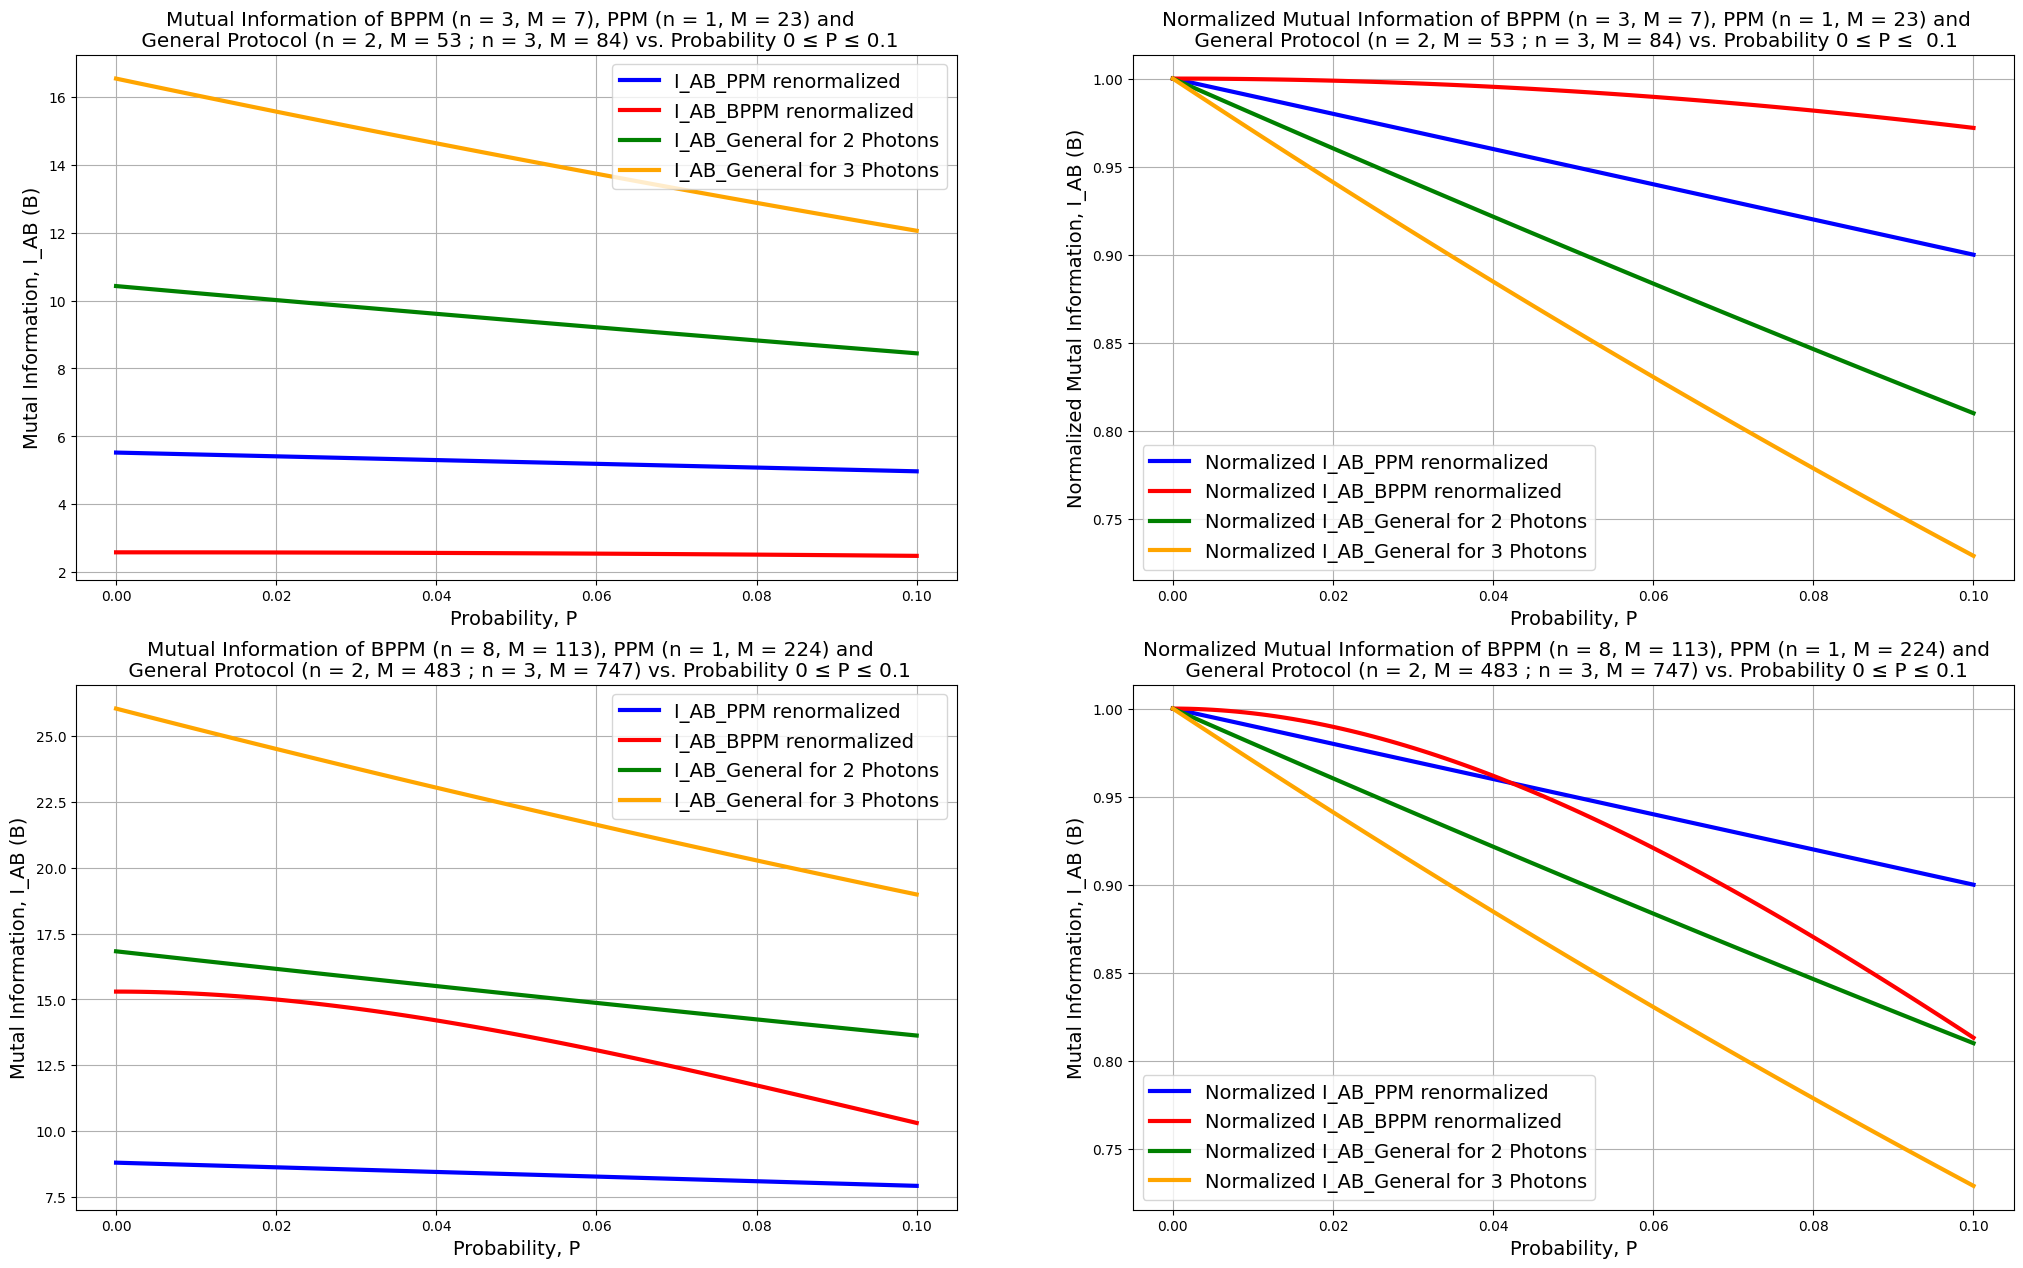

In [122]:
figure, axis = plt.subplots(2,2,figsize=(25,15))

axis[0, 0].plot(P_list, I_AB_PPM_list_3, label='I_AB_PPM renormalized', color ='blue', linewidth=3, alpha=1)
axis[0, 0].plot(P_list, I_AB_BPPM_list_3, label='I_AB_BPPM renormalized', color ='red', linewidth=3, alpha=1)
axis[0, 0].plot(P_list, I_AB_General_n2_list_3, label='I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
axis[0, 0].plot(P_list, I_AB_General_n3_list_3, label='I_AB_General for 3 Photons',color ='orange', linewidth=3, alpha=1)
axis[0, 0].set_title('Mutual Information of BPPM (n = 3, M = 7), PPM (n = 1, M = 23) and  \n General Protocol (n = 2, M = 53 ; n = 3, M = 84) vs. Probability 0 \u2264 P \u2264 0.1', fontsize='x-large')
axis[0, 0].set_xlabel('Probability, P ', fontsize = 14)
axis[0, 0].set_ylabel('Mutal Information, I_AB (B)', fontsize = 14)
axis[0, 0].grid(True)
axis[0, 0].legend(fontsize=14)

axis[0, 1].plot(P_list, Normalized_I_AB_PPM_list_3, label='Normalized I_AB_PPM renormalized', color ='blue', linewidth=3, alpha=1)
axis[0, 1].plot(P_list, Normalized_I_AB_BPPM_list_3, label='Normalized I_AB_BPPM renormalized', color ='red', linewidth=3, alpha=1)
axis[0, 1].plot(P_list, Normalized_I_AB_General_n2_list_3, label='Normalized I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
axis[0, 1].plot(P_list, Normalized_I_AB_General_n3_list_3, label='Normalized I_AB_General for 3 Photons',color ='orange', linewidth=3, alpha=1)
axis[0, 1].set_title('Normalized Mutual Information of BPPM (n = 3, M = 7), PPM (n = 1, M = 23) and  \n General Protocol (n = 2, M = 53 ; n = 3, M = 84) vs. Probability 0 \u2264 P \u2264  0.1', fontsize='x-large')
axis[0, 1].set_xlabel('Probability, P', fontsize = 14)
axis[0, 1].set_ylabel('Normalized Mutal Information, I_AB (B)', fontsize = 14)
axis[0, 1].grid(True)
axis[0, 1].legend(fontsize=14)

axis[1, 0].plot(P_list, I_AB_PPM_list_8, label='I_AB_PPM renormalized', color ='blue', linewidth=3, alpha=1)
axis[1, 0].plot(P_list, I_AB_BPPM_list_8, label='I_AB_BPPM renormalized', color ='red', linewidth=3, alpha=1)
axis[1, 0].plot(P_list, I_AB_General_n2_list_8, label='I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
axis[1, 0].plot(P_list, I_AB_General_n3_list_8, label='I_AB_General for 3 Photons',color ='orange', linewidth=3, alpha=1)
axis[1, 0].set_title('Mutual Information of BPPM (n = 8, M = 113), PPM (n = 1, M = 224) and  \n General Protocol (n = 2, M = 483 ; n = 3, M = 747) vs. Probability 0 \u2264 P \u2264 0.1', fontsize='x-large')
axis[1, 0].set_xlabel('Probability, P', fontsize = 14)
axis[1, 0].set_ylabel('Mutal Information, I_AB (B)', fontsize = 14)
axis[1, 0].grid(True)
axis[1, 0].legend(fontsize=14)

axis[1, 1].plot(P_list, Normalized_I_AB_PPM_list_8, label='Normalized I_AB_PPM renormalized', color ='blue', linewidth=3, alpha=1)
axis[1, 1].plot(P_list, Normalized_I_AB_BPPM_list_8, label='Normalized I_AB_BPPM renormalized', color ='red', linewidth=3, alpha=1)
axis[1, 1].plot(P_list, Normalized_I_AB_General_n2_list_8, label='Normalized I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
axis[1, 1].plot(P_list, Normalized_I_AB_General_n3_list_8, label='Normalized I_AB_General for 3 Photons',color ='orange', linewidth=3, alpha=1)
axis[1, 1].set_title('Normalized Mutual Information of BPPM (n = 8, M = 113), PPM (n = 1, M = 224) and  \n General Protocol (n = 2, M = 483 ; n = 3, M = 747) vs. Probability 0 \u2264 P \u2264 0.1', fontsize='x-large')
axis[1, 1].set_xlabel('Probability, P', fontsize = 14)
axis[1, 1].set_ylabel('Mutal Information, I_AB (B)', fontsize = 14)
axis[1, 1].grid(True)
axis[1, 1].legend(fontsize=14)

figure.set_facecolor("white")
plt.savefig('protocol/MI_EPI_4schemes_Plot.png', dpi=450, bbox_inches='tight')
plt.show()

## Second Transmission Rate = 0.157

### BPPM
    n = 4
    M = 14
### PPM
    n = 1
    M = 32
### General
    n = 2
    M = 72

    n = 3
    M = 114

In [20]:
import numpy as np
import matplotlib.pyplot as plt

I_AB_BPPM_list_4 = []
Normalized_I_AB_BPPM_list_4 = []

P_list = np.linspace(1e-6, 0.1, 101)

for P in P_list:
    n = 4
    N_n = compute_N(n)
    P_D_val = P_D(n, P, 0, 0, 0)

    P_AB_BPPM_val = P_AB_BPPM(n, P_D_val)

    H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
    H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
    H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
    I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
    I_AB_BPPM_list_4.append(I_AB_BPPM_val)
    Normalized_I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val) / I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, 0)
    Normalized_I_AB_BPPM_list_4.append(Normalized_I_AB_BPPM_val)

In [21]:
I_AB_PPM_list_4 = []
Normalized_I_AB_PPM_list_4 = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  n_PPM = 1
  M = 32
  P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   
  
  P_AB_PPM_val = P_AB_PPM(M) # P_AB_PPM(n, P)
  P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
  P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

  H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
  H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
  H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

  I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
  I_AB_PPM_list_4.append(I_AB_PPM_val)
  Normalized_I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val) / I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, 0)
  Normalized_I_AB_PPM_list_4.append(Normalized_I_AB_PPM_val)

In [22]:
I_AB_General_n2_list_4 = []

Normalized_I_AB_General_n2_list_4 = []

P_list = np.linspace(1e-6,0.1,101)


for P in P_list:
  n_General = 2
  T_General = 72 #compute_T_General(n_General, n_BPPM)

  P_D_General_val = P_D_General(n_General, P, 0, l=0, a=0)

  P_AB_General_diag_val = P_AB_diag_General(n_BPPM, n_General)

  H_A_General_val = H_A_General(P_AB_General_diag_val)
  H_B_General_val = H_B_General(P_AB_General_diag_val)
  H_AB_General_val = H_AB_General(P_AB_General_diag_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) 
  I_AB_General_n2_list_4.append(I_AB_General_val)
  
  Normalized_I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)  / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0)
  Normalized_I_AB_General_n2_list_4.append(Normalized_I_AB_General_val)



In [23]:
I_AB_General_n3_list_4 = []

Normalized_I_AB_General_n3_list_4 = []

P_list = np.linspace(1e-6,0.1,101)


for P in P_list:
  n_General = 3
  T_General = 114 #compute_T_General(n_General, n_BPPM)

  P_D_General_val = P_D_General(n_General, P, 0, l=0, a=0)

  P_AB_General_diag_val = P_AB_diag_General(n_BPPM, n_General)

  H_A_General_val = H_A_General(P_AB_General_diag_val)
  H_B_General_val = H_B_General(P_AB_General_diag_val)
  H_AB_General_val = H_AB_General(P_AB_General_diag_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) 
  I_AB_General_n3_list_4.append(I_AB_General_val)
  
  Normalized_I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)  / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0)
  Normalized_I_AB_General_n3_list_4.append(Normalized_I_AB_General_val)



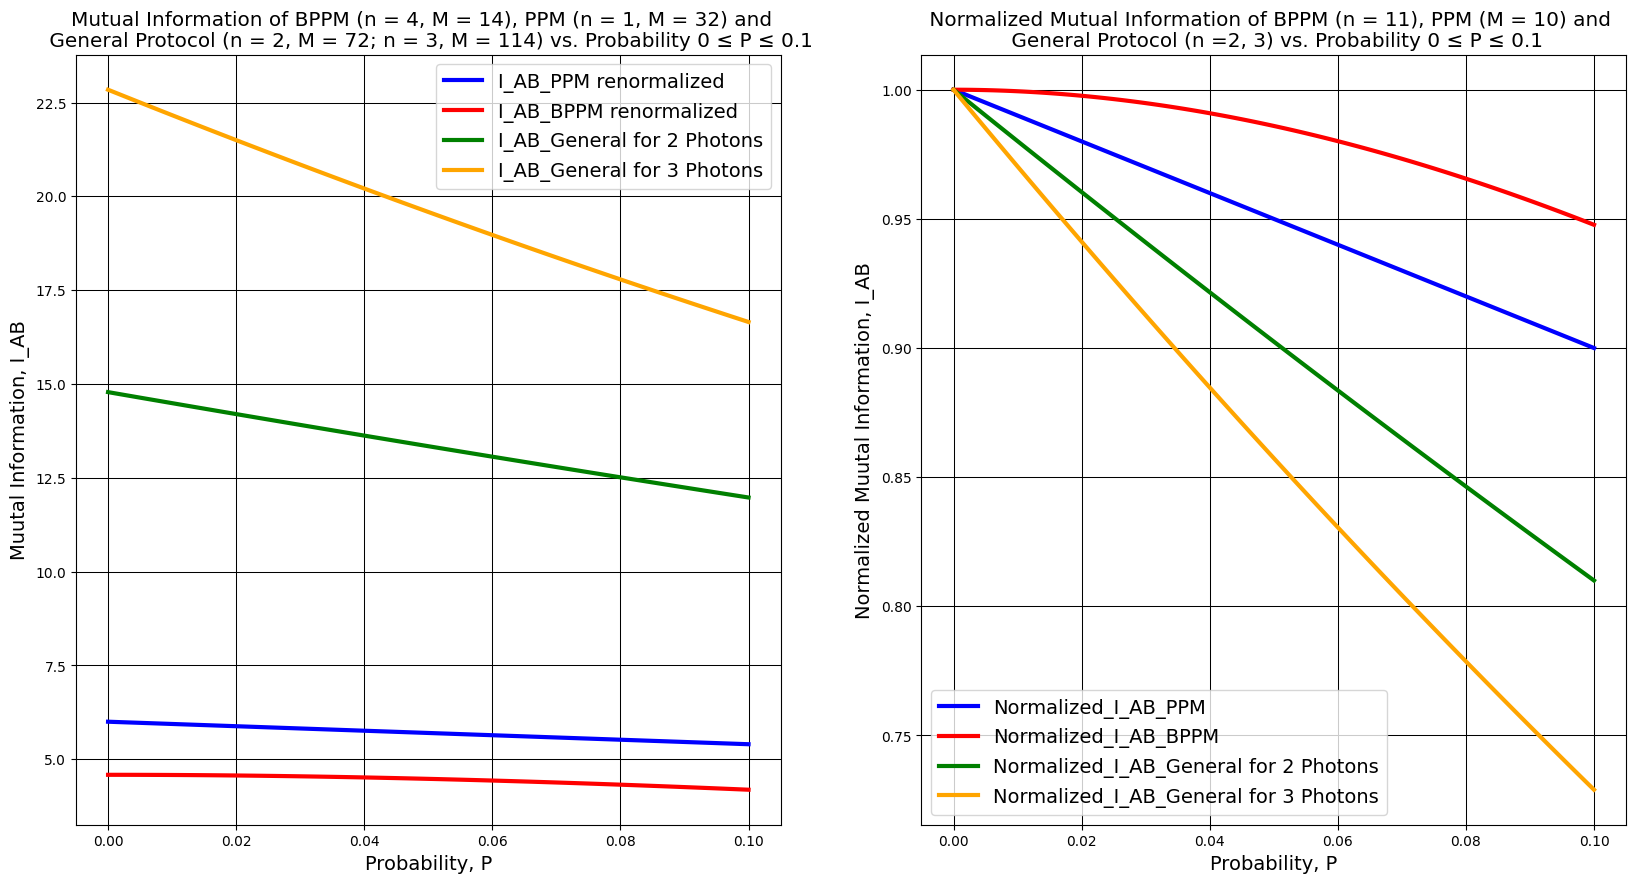

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))

ax1.plot(P_list, I_AB_PPM_list_4, label='I_AB_PPM renormalized',color ='blue', linewidth=3, alpha=1)
ax1.plot(P_list, I_AB_BPPM_list_4, label='I_AB_BPPM renormalized', color ='red',linewidth=3, alpha=1)
ax1.plot(P_list, I_AB_General_n2_list_4,label='I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
ax1.plot(P_list, I_AB_General_n3_list_4,label='I_AB_General for 3 Photons', color ='orange', linewidth=3, alpha=1)
ax1.set_xlabel('Probability, P', fontsize = 14)
ax1.set_ylabel('Muutal Information, I_AB', fontsize = 14)
ax1.set_title('Mutual Information of BPPM (n = 4, M = 14), PPM (n = 1, M = 32) and  \n General Protocol (n = 2, M = 72; n = 3, M = 114) vs. Probability 0 \u2264 P \u2264 0.1', fontsize='x-large')
ax1.grid(color='k', linestyle='-', linewidth=0.75)
ax1.legend(fontsize=14)

ax2.plot(P_list, Normalized_I_AB_PPM_list_4, label='Normalized_I_AB_PPM',color ='blue', linewidth=3, alpha=1)
ax2.plot(P_list, Normalized_I_AB_BPPM_list_4, label='Normalized_I_AB_BPPM',color ='red', linewidth=3, alpha=1)
ax2.plot(P_list, Normalized_I_AB_General_n2_list_4,label='Normalized_I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
ax2.plot(P_list, Normalized_I_AB_General_n3_list_4,label='Normalized_I_AB_General for 3 Photons', color ='orange', linewidth=3, alpha=1)
ax2.set_xlabel('Probability, P', fontsize = 14)
ax2.set_ylabel('Normalized Muutal Information, I_AB', fontsize = 14)
ax2.set_title(' Normalized Mutual Information of BPPM (n = 11), PPM (M = 10) and  \n General Protocol (n =2, 3) vs. Probability 0 \u2264 P \u2264 0.1', fontsize='x-large')
ax2.grid(color='k', linestyle='-', linewidth=0.75)
ax2.legend(fontsize=14)

fig.set_facecolor("white")
plt.savefig('protocol/MI_4_rate_4schemes_Plot.png', dpi=450, bbox_inches='tight')

plt.show()


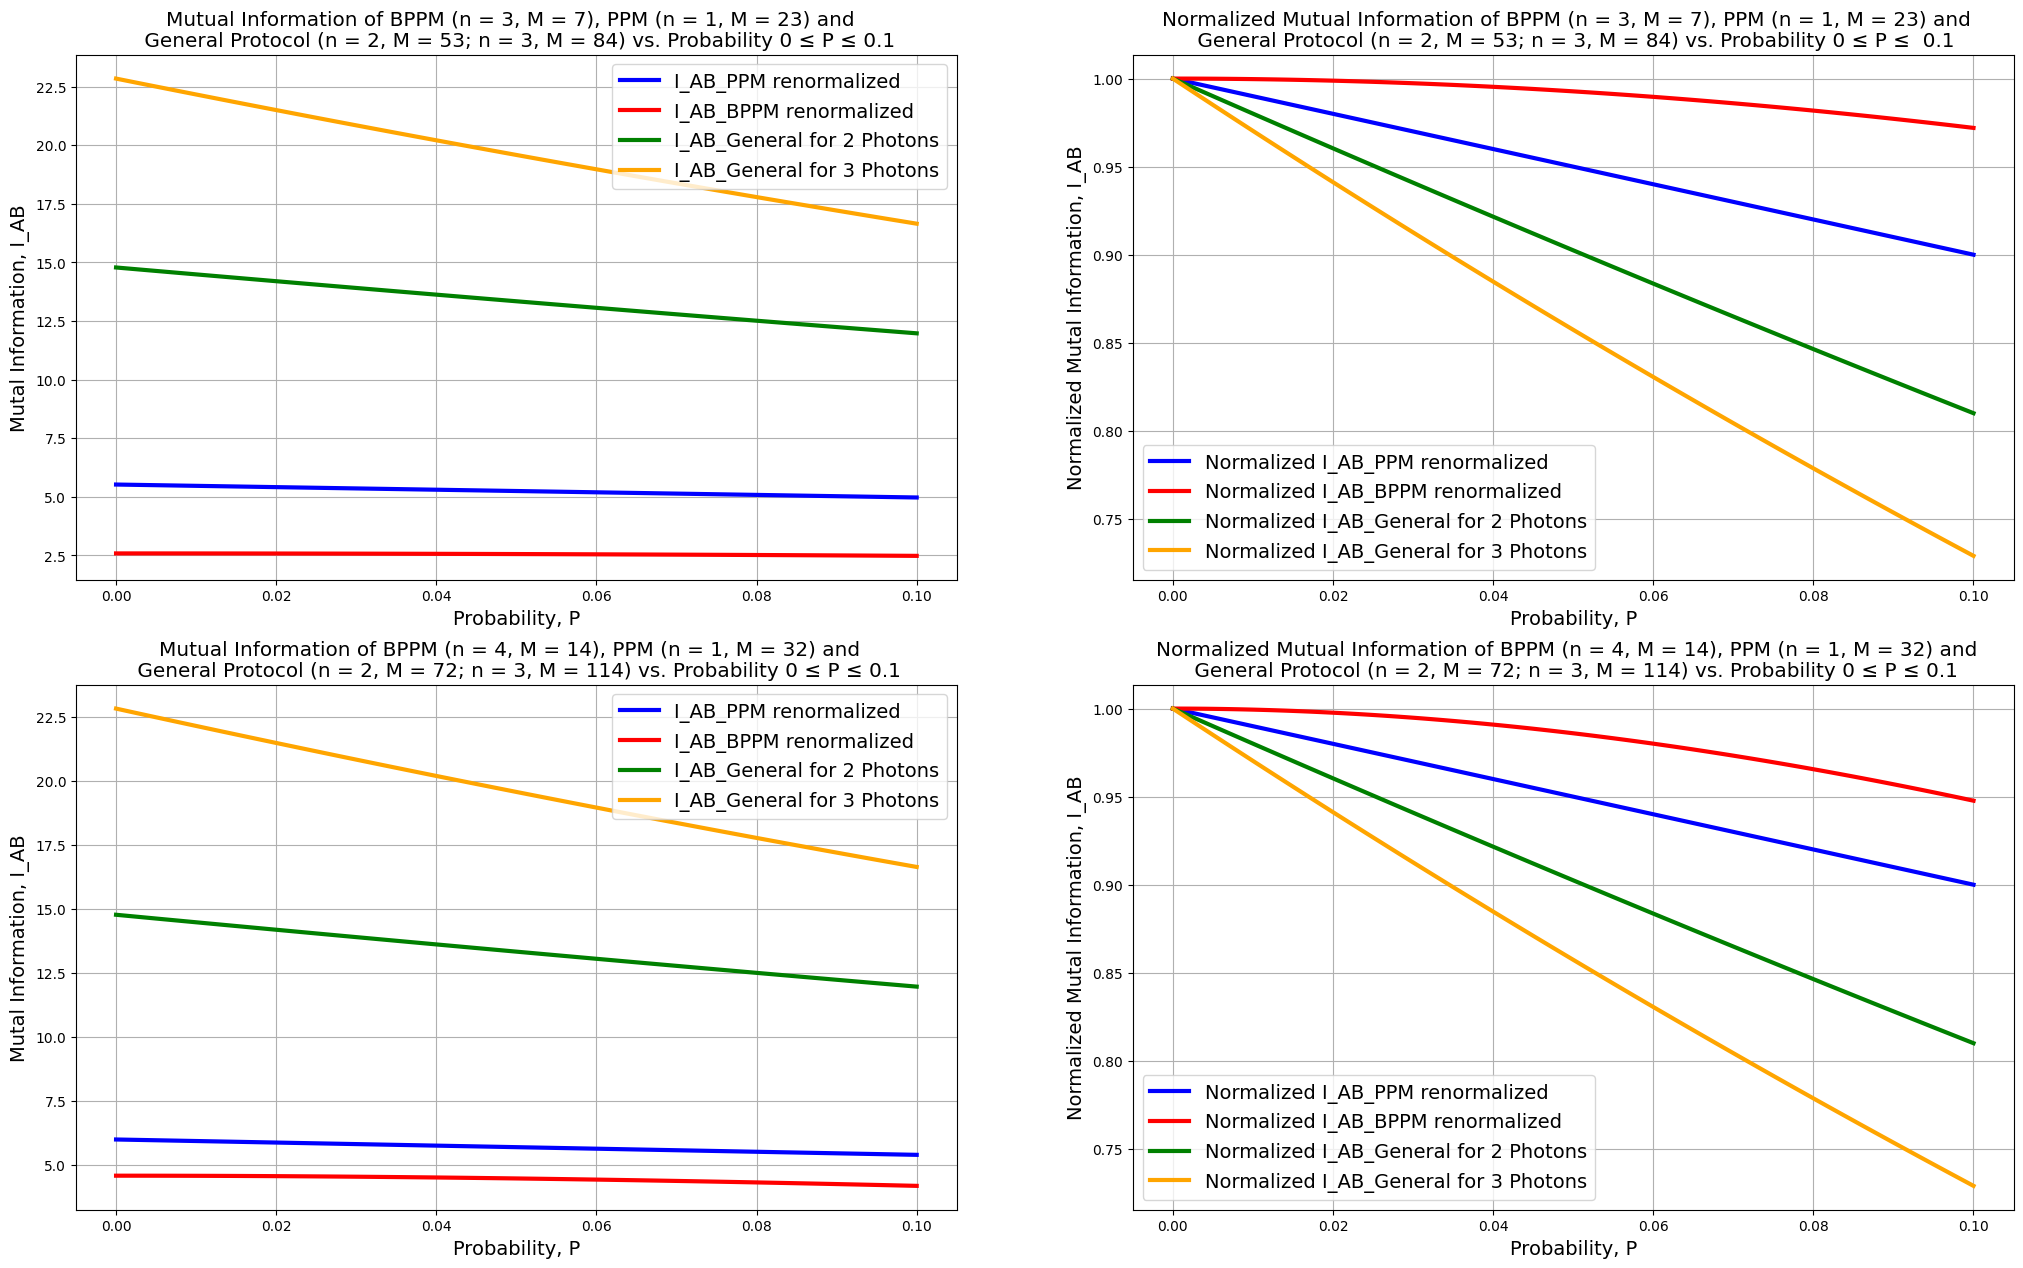

In [25]:
figure, axis = plt.subplots(2,2,figsize=(25,15))


axis[0, 0].plot(P_list, I_AB_PPM_list_3, label='I_AB_PPM renormalized', color ='blue', linewidth=3, alpha=1)
axis[0, 0].plot(P_list, I_AB_BPPM_list_3, label='I_AB_BPPM renormalized', color ='red', linewidth=3, alpha=1)
axis[0, 0].plot(P_list, I_AB_General_n2_list_3, label='I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
axis[0, 0].plot(P_list, I_AB_General_n3_list_3, label='I_AB_General for 3 Photons',color ='orange', linewidth=3, alpha=1)
axis[0, 0].set_title('Mutual Information of BPPM (n = 3, M = 7), PPM (n = 1, M = 23) and  \n General Protocol (n = 2, M = 53; n = 3, M = 84) vs. Probability 0 \u2264 P \u2264 0.1', fontsize='x-large')
axis[0, 0].set_xlabel('Probability, P', fontsize = 14)
axis[0, 0].set_ylabel('Mutal Information, I_AB', fontsize = 14)
axis[0, 0].grid(True)
axis[0, 0].legend(fontsize=14)

axis[0, 1].plot(P_list, Normalized_I_AB_PPM_list_3, label='Normalized I_AB_PPM renormalized', color ='blue', linewidth=3, alpha=1)
axis[0, 1].plot(P_list, Normalized_I_AB_BPPM_list_3, label='Normalized I_AB_BPPM renormalized', color ='red', linewidth=3, alpha=1)
axis[0, 1].plot(P_list, Normalized_I_AB_General_n2_list_3, label='Normalized I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
axis[0, 1].plot(P_list, Normalized_I_AB_General_n3_list_3, label='Normalized I_AB_General for 3 Photons',color ='orange', linewidth=3, alpha=1)
axis[0, 1].set_title('Normalized Mutual Information of BPPM (n = 3, M = 7), PPM (n = 1, M = 23) and  \n General Protocol (n = 2, M = 53; n = 3, M = 84) vs. Probability 0 \u2264 P \u2264  0.1', fontsize='x-large')
axis[0, 1].set_xlabel('Probability, P', fontsize = 14)
axis[0, 1].set_ylabel('Normalized Mutal Information, I_AB', fontsize = 14)
axis[0, 1].grid(True)
axis[0, 1].legend(fontsize=14)

axis[1, 0].plot(P_list, I_AB_PPM_list_4, label='I_AB_PPM renormalized', color ='blue', linewidth=3, alpha=1)
axis[1, 0].plot(P_list, I_AB_BPPM_list_4, label='I_AB_BPPM renormalized', color ='red', linewidth=3, alpha=1)
axis[1, 0].plot(P_list, I_AB_General_n2_list_4, label='I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
axis[1, 0].plot(P_list, I_AB_General_n3_list_4, label='I_AB_General for 3 Photons',color ='orange', linewidth=3, alpha=1)
axis[1, 0].set_title('Mutual Information of BPPM (n = 4, M = 14), PPM (n = 1, M = 32) and  \n General Protocol (n = 2, M = 72; n = 3, M = 114) vs. Probability 0 \u2264 P \u2264 0.1', fontsize='x-large')
axis[1, 0].set_xlabel('Probability, P', fontsize = 14)
axis[1, 0].set_ylabel('Mutal Information, I_AB', fontsize = 14)
axis[1, 0].grid(True)
axis[1, 0].legend(fontsize=14)

axis[1, 1].plot(P_list, Normalized_I_AB_PPM_list_4, label='Normalized I_AB_PPM renormalized', color ='blue', linewidth=3, alpha=1)
axis[1, 1].plot(P_list, Normalized_I_AB_BPPM_list_4, label='Normalized I_AB_BPPM renormalized', color ='red', linewidth=3, alpha=1)
axis[1, 1].plot(P_list, Normalized_I_AB_General_n2_list_4, label='Normalized I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
axis[1, 1].plot(P_list, Normalized_I_AB_General_n3_list_4, label='Normalized I_AB_General for 3 Photons',color ='orange', linewidth=3, alpha=1)
axis[1, 1].set_title('Normalized Mutual Information of BPPM (n = 4, M = 14), PPM (n = 1, M = 32) and  \n General Protocol (n = 2, M = 72; n = 3, M = 114) vs. Probability 0 \u2264 P \u2264 0.1', fontsize='x-large')
axis[1, 1].set_xlabel('Probability, P', fontsize = 14)
axis[1, 1].set_ylabel('Normalized Mutal Information, I_AB', fontsize = 14)
axis[1, 1].grid(True)
axis[1, 1].legend(fontsize=14)

figure.set_facecolor("white")
plt.savefig('protocol/MI_rate_4schemes_Plot.png', dpi=450, bbox_inches='tight')
plt.show()